In [4]:
using MAT
using PyPlot
using Random
using PyCall
using Statistics
using Distributions
using DelimitedFiles

In [40]:
function generate_complete_sorting(num_red, num_green, num_r_cluster, num_g_cluster, seed)
    
    Random.seed!(seed);
    
    # place red cells
    amountpercluster = [];
    cellsleft = num_red
    for j in 1:(num_r_cluster - 1)
        amounttaken = rand(1:cellsleft);
        push!(amountpercluster,amounttaken);
        cellsleft  = cellsleft - amounttaken;
    end
    push!(amountpercluster, cellsleft)
    
    redcellpos = Array{Float64}(undef, 0, 2);
    celltypes = ones(num_red,1);
    for i in 1:num_r_cluster
        clustercenter = rand(Uniform(-8,8),1,2);
        sigma = rand(Uniform(0.1,1),1,2);
        distribution = MvNormal(vec(clustercenter),vec(sigma));
        clustercells = transpose(rand(distribution,amountpercluster[i]));
        redcellpos = vcat(redcellpos,clustercells);
    end
    
    # place green cells
    amountperclusterg = [];
    cellsleft = num_green
    for j in 1:(num_g_cluster - 1)
        amounttaken = rand(1:cellsleft);
        push!(amountperclusterg,amounttaken);
        cellsleft  = cellsleft - amounttaken;
    end
    push!(amountperclusterg, cellsleft)
    greencellpos = Array{Float64}(undef, 0, 2)

    for i in 1:num_g_cluster
        clustercenter = rand(Uniform(-8,8),1,2);
        sigma = rand(Uniform(0.1,1),1,2);
        distribution = MvNormal(vec(clustercenter),vec(sigma));
        clustercells = transpose(rand(distribution,amountperclusterg[i]));
        greencellpos = vcat(greencellpos,clustercells);
    end
    
    cellpos = vcat(redcellpos,greencellpos);
    celltypes = vcat(celltypes, (ones(num_green,1)+ones(num_green,1)));
    file = matopen("complete_separation_pos.mat", "w");
    write(file, "positions", cellpos)
    close(file)
    file2 = matopen("complete_separation_types.mat", "w");
    write(file2, "types", celltypes)
    close(file2)
    
    return (cellpos, celltypes);
    
end

function plot_syn_data(cell_pos, cell_type)
    
    figure(figsize=(5,5), dpi=200)
    num_cells = size(cell_type)[1]
    for cid in range(1, stop=num_cells)
        if cell_type[cid] == 1.0
            scatter(cell_pos[cid,1], cell_pos[cid,2], color="red")
        elseif cell_type[cid] == 2
            scatter(cell_pos[cid,1], cell_pos[cid,2], color="green")
        else
            scatter(cell_pos[cid,1], cell_pos[cid,2], color="blue")
            write(stderr, "WARNING: More than 2 cell types")
        end                
    end
    xlim([-10, 10])
    ylim([-10, 10])
    xticks([])
    yticks([])
    
end;

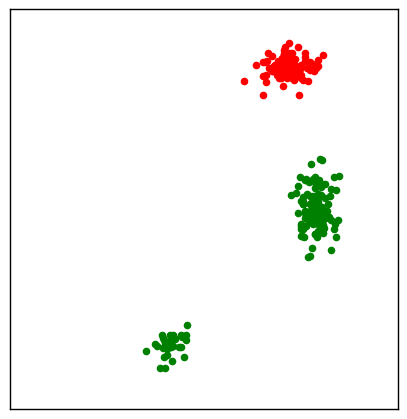

In [41]:
(cell_pos, cell_types) = generate_complete_sorting(100, 150, 1, 2, 123)
plot_syn_data(cell_pos, cell_types);

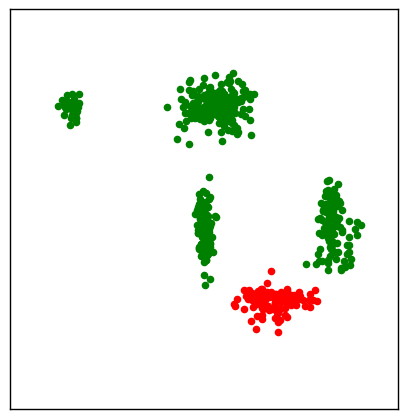

In [51]:
(cell_pos, cell_types) = generate_complete_sorting(100, 500, 1, 5, 31337)
plot_syn_data(cell_pos, cell_types);